<a href="https://colab.research.google.com/github/YLiu95/gpbcny/blob/main/improve_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## encoders reduce dimentionality, decoders increase dimentionality - RNN encoder-decoders

### introduction

this Colab notebook is the imporved implementation of my MSc project titled: **"Interpreting the market whisper: Applying RNN encoder-decoders to multistep forecast the price of pound sterling in Chinese yuan"**.

the original implementation is flawed since the encoders there does not decrease the dimentionality of the input data. The improved implementation of encoders here increase the dimentionality of the input data. Performance improvments are observed in two RNN encoder-decoders.

### GRU encoder-decoder, result: improved performance

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into training data and testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 100, 1) float64 
 testing data: (132, 100, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # the shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals]

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
# univariate GRU encoder-decoder
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform
# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
# define the GRU encoder
model.add(GRU(50, activation='relu', input_shape=(n_steps_in, n_features))) 
# repeat encoding
model.add(RepeatVector(n_steps_out))
# define the GRU decoder
model.add(GRU(100, activation='relu', 
              return_sequences=True)) 
# define the output model
model.add(TimeDistributed(Dense(50, activation='relu', kernel_initializer=init)))
model.add(TimeDistributed(Dense(1, kernel_initializer=init)))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                7950      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 50)           0         
 or)                                                             
                                                                 
 gru_5 (GRU)                 (None, 30, 100)           45600     
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 50)           5050      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            51        
 tributed)                                                       
                                                      

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 72.5451 - rmse: 8.5027
Epoch 1: val_rmse improved from inf to 5.33617, saving model to 23_checkpoint.keras
7/7 [==============================] - 8s 408ms/step - loss: 72.5451 - rmse: 8.5027 - val_loss: 28.5141 - val_rmse: 5.3362 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 27.8554 - rmse: 5.0546
Epoch 2: val_rmse improved from 5.33617 to 2.91089, saving model to 23_checkpoint.keras
7/7 [==============================] - 2s 300ms/step - loss: 27.8554 - rmse: 5.0546 - val_loss: 8.4879 - val_rmse: 2.9109 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 7.7064 - rmse: 2.7729
Epoch 3: val_rmse improved from 2.91089 to 2.53139, saving model to 23_checkpoint.keras
7/7 [==============================] - 2s 288ms/step - loss: 7.7064 - rmse: 2.7729 - val_loss: 6.4342 - val_rmse: 2.5314 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss:

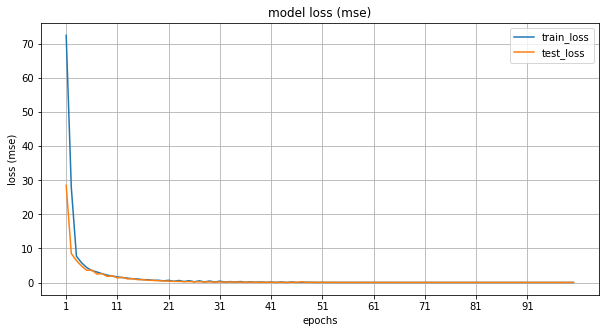

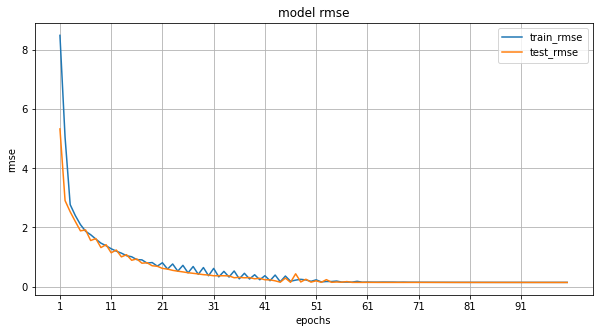

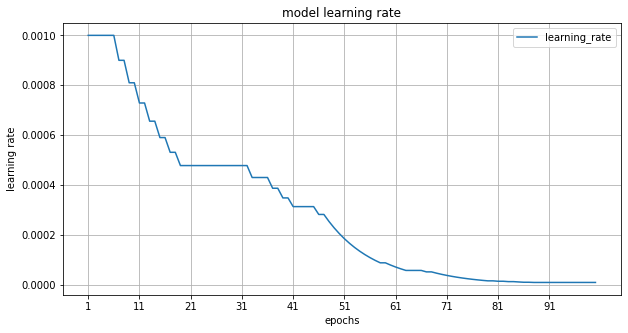

CPU times: user 4min 57s, sys: 40.9 s, total: 5min 38s
Wall time: 3min 36s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 28ms/step - loss: 0.0242 - rmse: 0.1395
CPU times: user 963 ms, sys: 26.8 ms, total: 990 ms
Wall time: 1.5 s


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.021426011014549003 
 test mse:  0.024205191518977223
 train rmse: 0.14324406512362697 
 test rmse:  0.15044860711476266
CPU times: user 1.23 s, sys: 26.5 ms, total: 1.26 s
Wall time: 1.38 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

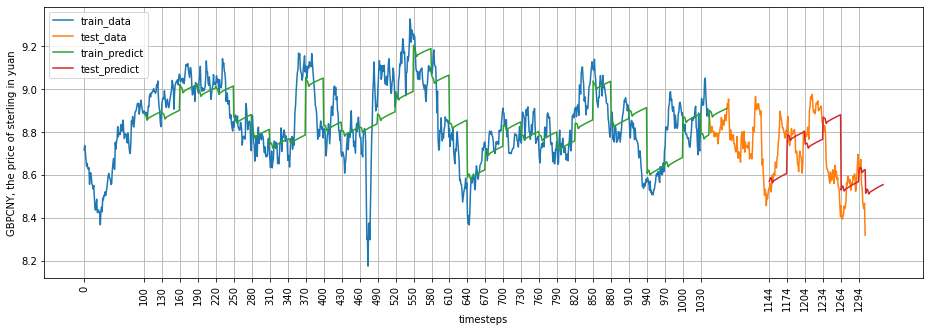

metrics calucalted with `model.evaluate()`: 
 train mse: 0.021426012739539146 
 test mse:  0.024205191060900688 
 train rmse: 0.13232003152370453 
 test rmse:  0.13949277997016907 
 metrics calucalted manually: 
 train mse: 0.021426011014549003 
 test mse:  0.024205191518977223 
 train rmse: 0.14324406512362697 
 test rmse:  0.15044860711476266 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.85111 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.702974 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.13336396 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.11234291


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

compare to flawed GRU encoder-decoder with metircs:
- metrics calucalted with `model.evaluate()`: 
- train mse: 0.03755016624927521 
- test mse:  0.021501140668988228 
- train rmse: 0.175779789686203 
- test rmse:  0.13478487730026245

#### the end of the section

### bidirectional GRU encoder-decoder, result: declined performance

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 100, 1) float64 
 testing data: (132, 100, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # the shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals]

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
# define the bidirectional GRU encoder
forward_layer = GRU(25, activation='relu')
backward_layer = GRU(25, activation='relu', go_backwards=True)
model.add(Bidirectional(forward_layer, 
                        backward_layer=backward_layer,
                        input_shape=(n_steps_in, n_features)))
# repeat encoding
model.add(RepeatVector(n_steps_out))
# define the GRU decoder
model.add(GRU(100, activation='relu', return_sequences=True)) 
# define the output model
model.add(TimeDistributed(Dense(50, activation='relu', kernel_initializer=init)))
model.add(TimeDistributed(Dense(1, kernel_initializer=init)))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 50)               4200      
 nal)                                                            
                                                                 
 repeat_vector_5 (RepeatVect  (None, 30, 50)           0         
 or)                                                             
                                                                 
 gru_14 (GRU)                (None, 30, 100)           45600     
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 50)           5050      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1)            51        
 stributed)                                           

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 73.4368 - rmse: 8.5574
Epoch 1: val_rmse improved from inf to 4.59245, saving model to 23_checkpoint.keras
7/7 [==============================] - 7s 572ms/step - loss: 73.4368 - rmse: 8.5574 - val_loss: 21.2403 - val_rmse: 4.5924 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 715.9747 - rmse: 14.2338
Epoch 2: val_rmse did not improve from 4.59245

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
7/7 [==============================] - 3s 467ms/step - loss: 715.9747 - rmse: 14.2338 - val_loss: 23.4526 - val_rmse: 4.8262 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 23.0538 - rmse: 4.7991
Epoch 3: val_rmse improved from 4.59245 to 4.55909, saving model to 23_checkpoint.keras
7/7 [==============================] - 3s 479ms/step - loss: 23.0538 - rmse: 4.7991 - val_loss: 20.9310 - val_rmse: 4.5591 - lr: 9.0000e-04
Epoch 4/100
7/7 [=

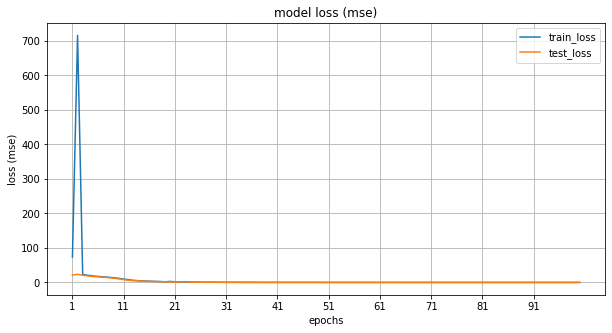

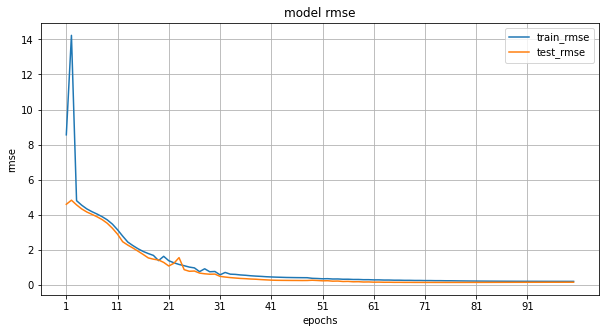

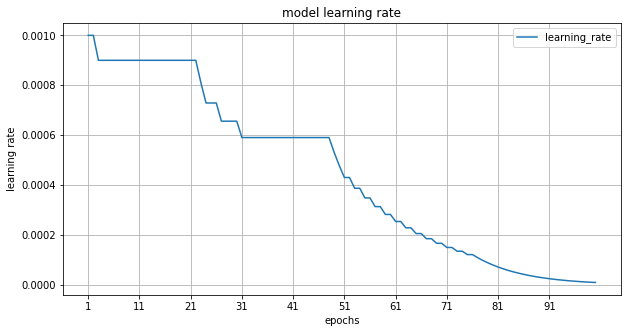

CPU times: user 8min 18s, sys: 1min 2s, total: 9min 20s
Wall time: 6min 25s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    model.evaluate(X_train, y_train)
    model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 44ms/step - loss: 0.0195 - rmse: 0.1325
CPU times: user 1.58 s, sys: 32 ms, total: 1.61 s
Wall time: 1.59 s


In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 45ms/step - loss: 0.0195 - rmse: 0.1325
CPU times: user 1.6 s, sys: 29.2 ms, total: 1.63 s
Wall time: 1.6 s


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.0451071757272814 
 test mse:  0.0194895543569744
 train rmse: 0.21232912145660782 
 test rmse:  0.139548237116853
CPU times: user 1.93 s, sys: 26.7 ms, total: 1.96 s
Wall time: 1.97 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

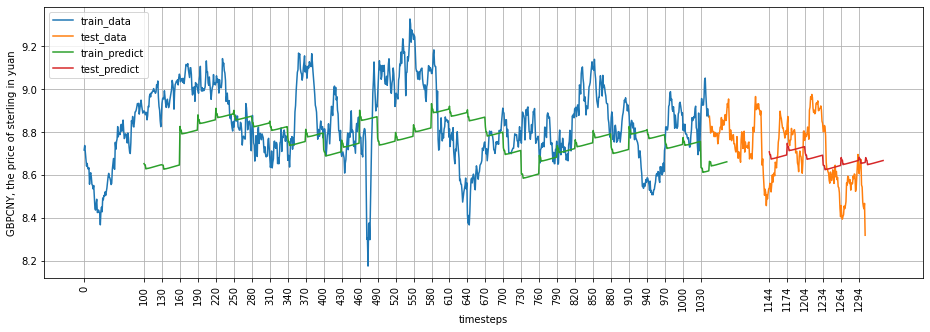

metrics calucalted with `model.evaluate()`: 
 train mse: 0.0451071634888649 
 test mse:  0.019489556550979614 
 train rmse: 0.19617682695388794 
 test rmse:  0.13245752453804016 
 metrics calucalted manually: 
 train mse: 0.0451071757272814 
 test mse:  0.0194895543569744 
 train rmse: 0.21232912145660782 
 test rmse:  0.139548237116853 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.767567 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.677517 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.075602315 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.03257595


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

performace declined compare to flawed bidirectional GRU encoder-decoder:
- metrics calucalted with `model.evaluate()`: 
- train mse: 0.0361340157687664 
- test mse:  0.017722204327583313 
- train rmse: 0.17656706273555756 
- test rmse:  0.12243817746639252

#### the end of the section

### CNN-GRU encoder-decoder, result: improved performance

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 100, 1) float64 
 testing data: (132, 100, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # the shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals]

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform

# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
# define the CNN encoder
model.add(Conv1D(filters=3, kernel_size=28, strides=3, activation='relu', 
                 input_shape=(n_steps_in, n_features)))
model.add(Conv1D(filters=5, kernel_size=16, activation='relu'))
#model.add(MaxPooling1D(pool_size=7, strides=1))
model.add(Flatten())
# repeat encoding
model.add(RepeatVector(n_steps_out))
# define the GRU decoder
#model.add(GRU(1024, activation='relu', return_sequences=True))
model.add(GRU(100, activation='relu', return_sequences=True)) 
# define the output model
model.add(TimeDistributed(Dense(50, activation='relu', kernel_initializer=init)))
model.add(TimeDistributed(Dense(1, kernel_initializer=init)))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 3)             87        
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 5)             245       
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 50)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 30, 100)           45600     
                                                                 
 time_distributed (TimeDistr  (None, 30, 50)           5050      
 ibuted)                                                

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 54.0684 - rmse: 6.9089
Epoch 1: val_rmse improved from inf to 2.19973, saving model to 23_checkpoint.keras
7/7 [==============================] - 17s 291ms/step - loss: 54.0684 - rmse: 6.9089 - val_loss: 4.7899 - val_rmse: 2.1997 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 3.4775 - rmse: 1.7739
Epoch 2: val_rmse improved from 2.19973 to 1.58303, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 98ms/step - loss: 3.4775 - rmse: 1.7739 - val_loss: 2.5825 - val_rmse: 1.5830 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 2.3605 - rmse: 1.5182
Epoch 3: val_rmse improved from 1.58303 to 1.25314, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 96ms/step - loss: 2.3605 - rmse: 1.5182 - val_loss: 1.5505 - val_rmse: 1.2531 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 1.8

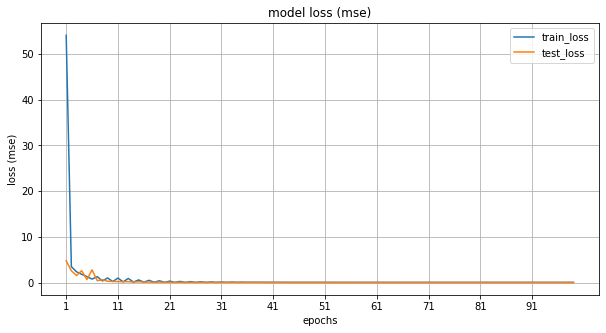

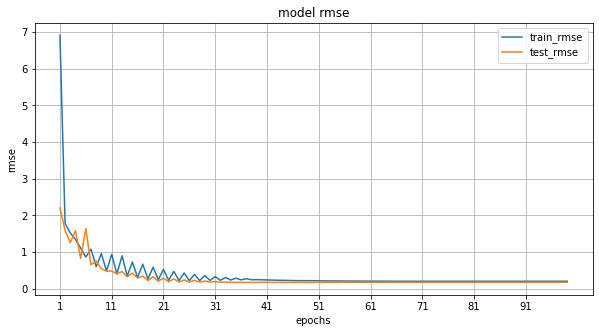

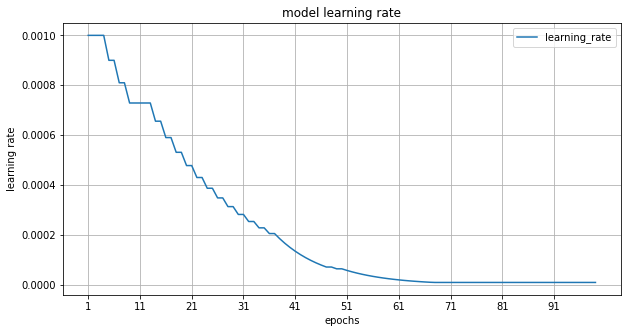

CPU times: user 1min 33s, sys: 12.3 s, total: 1min 46s
Wall time: 1min 21s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 8ms/step - loss: 0.0319 - rmse: 0.1686
CPU times: user 401 ms, sys: 20.8 ms, total: 422 ms
Wall time: 413 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.04641656431446485 
 test mse:  0.03192991043732597
 train rmse: 0.21501276290768193 
 test rmse:  0.17863900823024575
CPU times: user 605 ms, sys: 23.4 ms, total: 628 ms
Wall time: 681 ms


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.789738

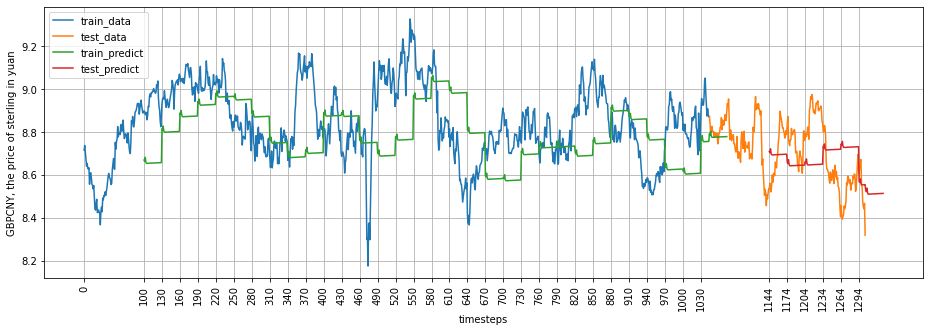

metrics calucalted with `model.evaluate()`: 
 train mse: 0.04641656205058098 
 test mse:  0.03192991390824318 
 train rmse: 0.19803974032402039 
 test rmse:  0.1685529202222824 
 metrics calucalted manually: 
 train mse: 0.04641656431446485 
 test mse:  0.03192991043732597 
 train rmse: 0.21501276290768193 
 test rmse:  0.17863900823024575 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.789738 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.667508 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.12213793 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.054950483


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

performace improved.
metrices from flawed CNN-GRU encoder-decoder:
- metrics calucalted with `model.evaluate()`: 
- train mse: 0.06126480922102928 
- test mse:  0.025416381657123566 
- train rmse: 0.22355590760707855 
- test rmse:  0.15571586787700653

#### the end of the section

### convLSTM encoder-decoder, result: declined performance

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 5, 20, 1) float64 
 testing data: (132, 5, 20, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # the shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals]

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import ConvLSTM1D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform
# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
# define the convLSTM encoder
model.add(ConvLSTM1D(filters=10, kernel_size=12, strides=2,
           input_shape=(n_seq, n_steps, n_features)))
model.add(Flatten())
# repeat encoding
model.add(RepeatVector(n_steps_out))
# define the GRU decoder
model.add(GRU(100, activation='relu', return_sequences=True)) 
# define the output model
model.add(TimeDistributed(Dense(50, activation='relu', kernel_initializer=init)))
model.add(TimeDistributed(Dense(1, kernel_initializer=init)))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_3 (ConvLSTM1D)  (None, 5, 10)             5320      
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 50)           0         
 or)                                                             
                                                                 
 gru_3 (GRU)                 (None, 30, 100)           45600     
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 50)           5050      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1)           

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 75.1034 - rmse: 8.6593
Epoch 1: val_rmse improved from inf to 6.48578, saving model to 23_checkpoint.keras
7/7 [==============================] - 7s 283ms/step - loss: 75.1034 - rmse: 8.6593 - val_loss: 42.3636 - val_rmse: 6.4858 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 48.5002 - rmse: 6.7798
Epoch 2: val_rmse improved from 6.48578 to 4.75165, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 130ms/step - loss: 48.5002 - rmse: 6.7798 - val_loss: 22.7957 - val_rmse: 4.7517 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 16.6216 - rmse: 4.0471
Epoch 3: val_rmse improved from 4.75165 to 3.47564, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 135ms/step - loss: 16.6216 - rmse: 4.0471 - val_loss: 12.1772 - val_rmse: 3.4756 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - l

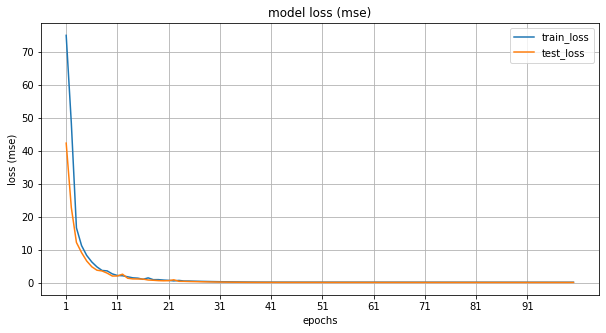

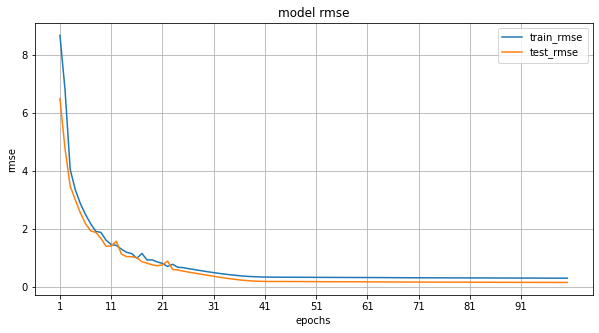

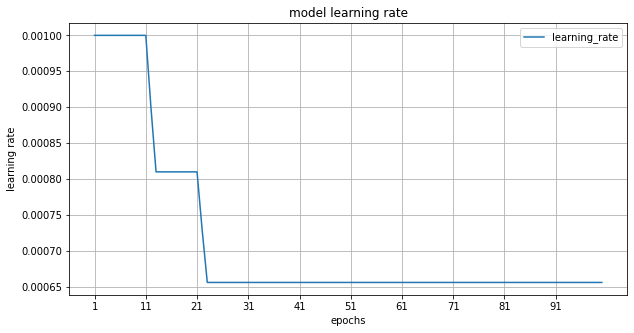

CPU times: user 2min 16s, sys: 15 s, total: 2min 31s
Wall time: 2min 26s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 14ms/step - loss: 0.0339 - rmse: 0.1588
CPU times: user 563 ms, sys: 25.1 ms, total: 588 ms
Wall time: 549 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
train_predict = train_predict.reshape((train_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
test_predict = test_predict.reshape((test_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('all training data for prediction:', train_predict.shape, train_predict.dtype, '\n',
      'all testing data for prediction:', test_predict.shape, test_predict.dtype)

all training data for prediction: (944, 5, 20, 1) float64 
 all testing data for prediction: (161, 5, 20, 1) float64


In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.09533896489597572 
 test mse:  0.03390423470780557
 train rmse: 0.30840480995104935 
 test rmse:  0.18391495453775766
CPU times: user 954 ms, sys: 26.2 ms, total: 980 ms
Wall time: 932 ms


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.600412

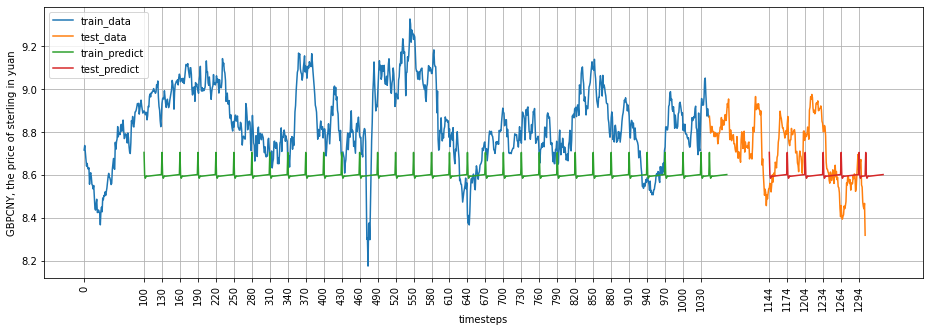

metrics calucalted with `model.evaluate()`: 
 train mse: 0.09533896297216415 
 test mse:  0.033904243260622025 
 train rmse: 0.2844584286212921 
 test rmse:  0.1588466763496399 
 metrics calucalted manually: 
 train mse: 0.09533896489597572 
 test mse:  0.03390423470780557 
 train rmse: 0.30840480995104935 
 test rmse:  0.18391495453775766 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.600412 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.600412 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.01968247 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.019682461


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

performance declined compared to flawed convLSTM encoder-deocder:
- metrics calucalted with `model.evaluate()`: 
- train mse: 0.058769214898347855 
- test mse:  0.022925667464733124 
- train rmse: 0.2169293910264969 
- test rmse:  0.14759452641010284

#### the end of the section

### bidirectional convLSTM encoder-decoder, result: declined performance

#### data prepration

In [ ]:
# import the data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/YLiu95/gpbcny/main/5year%202017-2022.csv')
df

,date,price
0,2022/1/14,8.7158
1,2022/1/13,8.7370
2,2022/1/12,8.7050
3,2022/1/11,8.6703
4,2022/1/10,8.6409
...,...,...
1300,2017/1/20,8.4733
1301,2017/1/19,8.4523
1302,2017/1/18,8.4416
1303,2017/1/17,8.4670


In [ ]:
# transfer the data into an array
import numpy as np

data_array = df[['price']].to_numpy()
data_array = data_array.reshape(data_array.shape[0])
data_array.shape, data_array

((1305,), array([8.7158, 8.737 , 8.705 , ..., 8.4416, 8.467 , 8.3182]))

In [ ]:
# splitting the data into the training data and the testing data
train_size=int(len(data_array)*0.8)
test_size=len(data_array)-train_size
train_data=data_array[0:train_size]
test_data=data_array[train_size:len(data_array)]

In [ ]:
train_size, test_size

(1044, 261)

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
# split a univariate sequence into samples for multistep forecasting
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# univariate data preparation
from numpy import array

# choose the number of timesteps
n_steps_in = 100 # input timesteps
n_steps_out = 30 # output timesteps
# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
# summarise the data
print('training data:', '\n')
for i in range(2):
    print(X_train[i], y_train[i])
print('\n', 'testing data:', '\n')
for i in range(2):
    print(X_test[i], y_test[i])

training data: 

[8.7158 8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8.5564
 8.6013 8.6099 8.5894 8.5564 8.5508 8.5344 8.5503 8.4962 8.4448 8.4357
 8.4665 8.4864 8.4245 8.4247 8.4362 8.4272 8.4214 8.3669 8.4307 8.4495
 8.4277 8.4918 8.4837 8.5039 8.5001 8.5207 8.5045 8.5203 8.5388 8.5649
 8.592  8.6071 8.5904 8.5857 8.5741 8.5548 8.5604 8.6236 8.6509 8.6765
 8.6298 8.6261 8.7517 8.7196 8.7546 8.7675 8.8252 8.7773 8.7978 8.7957
 8.7881 8.8274 8.8358 8.8035 8.8183 8.8556 8.8074 8.7692 8.7736 8.7915
 8.7893 8.7862 8.7486 8.7955 8.7725 8.7311 8.7053 8.6996 8.7507 8.8528
 8.84   8.8724 8.8266 8.8235 8.8509 8.8931 8.8953 8.9032 8.9174 8.9328
 8.9236 8.9339 8.8834 8.9079 8.9267 8.9486 8.9235 8.9057 8.888  8.8957] [8.8982 8.8955 8.8813 8.8811 8.8915 8.8566 8.8757 8.9196 8.9167 8.9662
 8.9772 8.9637 8.9826 8.9815 8.9897 8.9901 9.0025 8.9897 8.9897 8.9806
 8.9869 9.0205 9.0089 9.038  8.962  8.9191 8.902  8.852  8.8247 8.8795]
[8.737  8.705  8.6703 8.6409 8.6535 8.6329 8.6265 8.6332 8

In [ ]:
train_data.shape, test_data.shape

((1044,), (261,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((915, 100), (915, 30), (132, 100), (132, 30))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('training data:', X_train.shape, X_train.dtype, '\n',
      'testing data:', X_test.shape, X_test.dtype)

training data: (915, 5, 20, 1) float64 
 testing data: (132, 5, 20, 1) float64


#### metric function and callback

In [ ]:
# define a root mean square error (rmse) metric function
from tensorflow.keras.backend import square, mean

def rmse(y_true, y_pred):
    """
    calculate the root mean square error between y_true and y_pred

    y_true is the label
    y_pred is the model's prediction
    """
    # the shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals]

    # calculate the root mean square error and use it as a metric function
    rmse = (mean(square(y_true - y_pred)))**0.5
    
    return rmse

Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_rmse',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_rmse',
                                        patience=50, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_rmse',
                                       factor=0.9,
                                       min_lr=1e-5,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### model defination and training

In [ ]:
# univariate GRU encoder-decoder
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import ConvLSTM1D
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.initializers import RandomUniform
# define kernal initialiser
init = RandomUniform(minval=-0.03, maxval=0.03)

# define the model
model = Sequential()
# define the bidirectional conLSTM encoder
forward_layer = ConvLSTM1D(filters=5, kernel_size=12, strides=2,)
backward_layer = ConvLSTM1D(filters=5, kernel_size=12, strides=2,
                            go_backwards=True)
model.add(Bidirectional(forward_layer, 
                        backward_layer=backward_layer,
                        input_shape=(n_seq, n_steps, n_features)))
model.add(Flatten())
# repeat encoding
model.add(RepeatVector(n_steps_out))
# define the GRU decoder
model.add(GRU(100, activation='relu', return_sequences=True)) 
# define the output model
model.add(TimeDistributed(Dense(50, activation='relu', kernel_initializer=init)))
model.add(TimeDistributed(Dense(1, kernel_initializer=init)))

model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=rmse)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 5, 10)            2920      
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 50)           0         
 or)                                                             
                                                                 
 gru_1 (GRU)                 (None, 30, 100)           45600     
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 50)           5050      
 tributed)                                                       
                                                      

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 75.4820 - rmse: 8.6820
Epoch 1: val_rmse improved from inf to 5.53427, saving model to 23_checkpoint.keras
7/7 [==============================] - 21s 325ms/step - loss: 75.4820 - rmse: 8.6820 - val_loss: 30.7506 - val_rmse: 5.5343 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 39.1020 - rmse: 6.1413
Epoch 2: val_rmse did not improve from 5.53427

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
7/7 [==============================] - 1s 149ms/step - loss: 39.1020 - rmse: 6.1413 - val_loss: 33.4535 - val_rmse: 5.7594 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 21.2141 - rmse: 4.5199
Epoch 3: val_rmse improved from 5.53427 to 3.52100, saving model to 23_checkpoint.keras
7/7 [==============================] - 1s 150ms/step - loss: 21.2141 - rmse: 4.5199 - val_loss: 12.4969 - val_rmse: 3.5210 - lr: 9.0000e-04
Epoch 4/100
7/7 [====

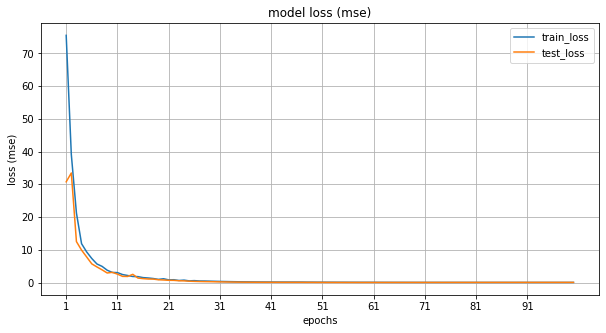

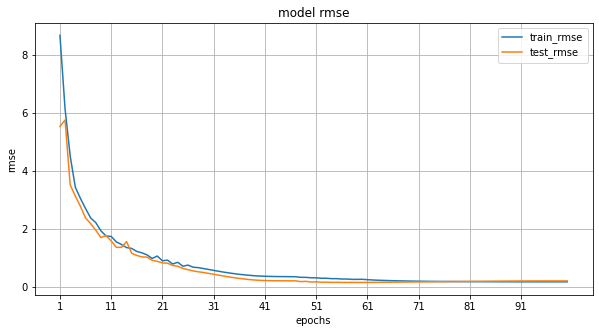

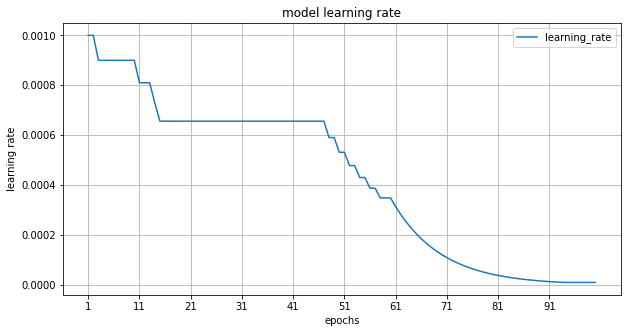

CPU times: user 2min 41s, sys: 18.9 s, total: 3min
Wall time: 2min 29s


In [ ]:
%%time
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

num_epochs = 100
# fit model
with tf.device('GPU'):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=num_epochs, steps_per_epoch=7, shuffle=False,
                    callbacks=callbacks)

# plot the training and testing loss (mse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'])
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'])
plt.xticks(np.arange(1, len(history.history['loss'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

# plot the training and testing metric (rmse)
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['rmse'])+1)), history.history['rmse'])
plt.plot(list(range(1, len(history.history['val_rmse'])+1)), history.history['val_rmse'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epochs')
plt.grid()
plt.legend(['train_rmse', 'test_rmse'], loc='upper right')
plt.show()

# plot the learning rate
plt.figure(figsize=(10,5))
plt.plot(list(range(1, len(history.history['lr'])+1)), history.history['lr'])
plt.xticks(np.arange(1, len(history.history['rmse'])+1, 1.0))
plt.locator_params(axis='x', nbins=10)
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epochs')
plt.grid()
plt.legend(['learning_rate'], loc='upper right')
plt.show()

Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the testing data for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the testing data.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### model evaluation

In [ ]:
# model evaluation with `model.evaluate()`
%%time
with tf.device('GPU'):
    eva_train = model.evaluate(X_train, y_train)
    eva_test = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 15ms/step - loss: 0.0242 - rmse: 0.1512
CPU times: user 646 ms, sys: 26.4 ms, total: 672 ms
Wall time: 635 ms


In [ ]:
"""
to utilise all training and testing data for prediction:
 
split the training and testing data into samples without 
considering the creation of labels
"""
def split_seq(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

In [ ]:
train_predict = split_seq(train_data, n_steps_in)
test_predict = split_seq(test_data, n_steps_in)

In [ ]:
train_predict.shape, test_predict.shape

((944, 100), (161, 100))

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, features]
n_features = 1 # number of features
n_seq = 5 # number of subsequence
n_steps = 20 # number of timesteps per susequence
train_predict = train_predict.reshape((train_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')
test_predict = test_predict.reshape((test_predict.shape[0], n_seq, n_steps, 
                           n_features)).astype('float64')

print('all training data for prediction:', train_predict.shape, train_predict.dtype, '\n',
      'all testing data for prediction:', test_predict.shape, test_predict.dtype)

all training data for prediction: (944, 5, 20, 1) float64 
 all testing data for prediction: (161, 5, 20, 1) float64


In [ ]:
# verifiy the model evaluation results by calculating 
# the mse between the model prediciton and the label
%%time
with tf.device('GPU'): 
    train_predict=model.predict(train_predict)
    test_predict=model.predict(test_predict)
from sklearn.metrics import mean_squared_error
train_predict = np.squeeze(train_predict)
test_predict = np.squeeze(test_predict)
train_mse = mean_squared_error(y_train,train_predict[:len(X_train)])
test_mse = mean_squared_error(y_test,test_predict[:len(X_test)])
train_rmse = mean_squared_error(y_train,train_predict[:len(X_train)], 
                                squared=False)
test_rmse = mean_squared_error(y_test,test_predict[:len(X_test)],
                               squared=False)

print(' train mse:', train_mse, '\n', 'test mse: ', test_mse)
print(' train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse)

 train mse: 0.05843402714805082 
 test mse:  0.024169694338956767
 train rmse: 0.24070505265786377 
 test rmse:  0.1553714878265781
CPU times: user 1.26 s, sys: 41.9 ms, total: 1.3 s
Wall time: 1.6 s


#### visualise the results

In [ ]:
"""
since the training data are generated using the sliding window method,
the prediction sequences are also overlapped. thus we need to
generate a single sequence of predicted values for visualisation
"""
def concate_pred_seq(data_seq, pred_seq, n_steps_in, n_steps_out):
    con_seq, a_seq = list(), list()
    """
    number of full lenght predicted sub sequences placed 
    within the trian/test sequence
    """
    num_sub_pred_seq = (len(data_seq) - n_steps_in)//n_steps_out 
    """
    length of the predicted sub sequence placed before 
    the end of the train/test sequence
    """
    mid_len = len(data_seq)-n_steps_in-num_sub_pred_seq*n_steps_out
    """
    index of the predicted sub sequence placed before 
    the end of the train/test sequence
    """ 
    mid_seq_idx = num_sub_pred_seq*n_steps_out 
    for i in range(num_sub_pred_seq):
        a_seq = pred_seq[i*n_steps_out]
        con_seq.append(a_seq)
    con_seq = array(con_seq)
    con_seq = con_seq.reshape(con_seq.shape[0]*con_seq.shape[1])
    if mid_len > 0:
        con_seq = np.concatenate((con_seq, 
                            pred_seq[mid_seq_idx,:mid_len],
                            pred_seq[-1]))
    else:
        con_seq = np.concatenate((con_seq, pred_seq[-1]))
    return con_seq

In [ ]:
train_pred_seq = concate_pred_seq(train_data, train_predict, n_steps_in, n_steps_out)
test_pred_seq = concate_pred_seq(test_data, test_predict, n_steps_in, n_steps_out)

In [ ]:
train_pred_seq.shape, test_pred_seq.shape

((974,), (191,))

In [ ]:
len(data_array)+n_steps_out+200

1535

In [ ]:
"""
position the sequences onto the correct locations 
on a long data array for visulisation
"""
# generate a long enough empty sequence for plotting
train_predict_plot = np.empty(len(data_array)+n_steps_out+200) 
# clear the values inside the sequence
train_predict_plot[:] = np.nan 
# input the predicted values at the correct location
train_predict_plot[n_steps_in:n_steps_in+len(train_pred_seq)] = train_pred_seq 

# repeat the above steps for other sequneces
test_predict_plot = np.empty(len(data_array)+n_steps_out+200)
test_predict_plot[:] = np.nan
test_predict_plot[len(train_data)+n_steps_in:len(train_data)+n_steps_in+
                  len(test_pred_seq)] = test_pred_seq

test_data_plot = np.empty(len(data_array)+n_steps_out+200)
test_data_plot[:] = np.nan
test_data_plot[len(train_data):len(train_data)+
                  len(test_data)] = test_data

In [ ]:
len(test_data)

261

In [ ]:
# generate ticks for visulisation
ticks = list([0]+
        # marking every output timestep form training prediction
        [n_steps_in+i*n_steps_out for i in range(0,len(train_data)//n_steps_out-2)]+ 
        # this line is hidden [len(train_data)+len(test_data),len(train_data)+len(test_data)+n_steps_out]+
        # marking every output timestep form testing prediction
        [len(train_data)+n_steps_in+i*n_steps_out for i in range(0,len(test_data)//n_steps_out-2)]) 

In [ ]:
train_predict.mean()

8.689327

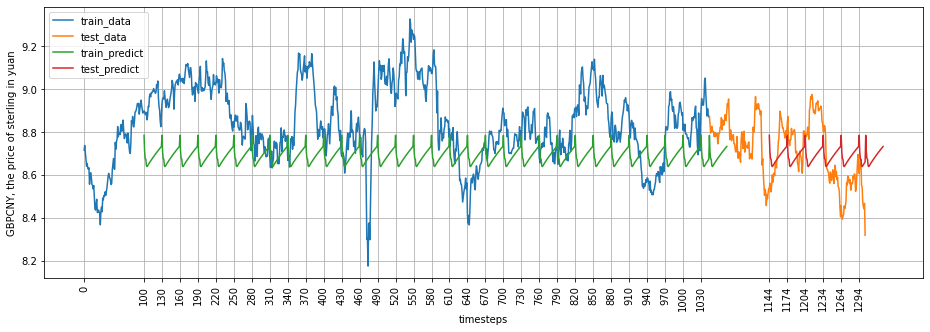

metrics calucalted with `model.evaluate()`: 
 train mse: 0.058434028178453445 
 test mse:  0.024169698357582092 
 train rmse: 0.21725055575370789 
 test rmse:  0.1512342393398285 
 metrics calucalted manually: 
 train mse: 0.05843402714805082 
 test mse:  0.024169694338956767 
 train rmse: 0.24070505265786377 
 test rmse:  0.1553714878265781 
 
 training data mean:    8.841544827586207 
 train prediction mean: 8.689327 
 testing data mean:     8.717213409961685 
 test prediction mean:  8.689326 
 
 training data standard deviation:    0.17639548961572413 
 train prediction standard deviation: 0.032663994 
 testing data standard deviation:     0.14175250034034664 
 test prediction standard deviation:  0.032664016


In [ ]:
# visualise the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15.75,5))
ax.set_xticks(ticks,minor=False)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
plt.xticks(rotation=90)
plt.ylabel('GBPCNY, the price of sterling in yuan')
plt.xlabel('timesteps')
ax.plot(train_data, label='train_data')
ax.plot(test_data_plot, label='test_data')
ax.plot(train_predict_plot, label='train_predict')
ax.plot(test_predict_plot, label='test_predict')
ax.legend(loc='upper left')
plt.show()
# print some relevant metrics and statistics
print('metrics calucalted with `model.evaluate()`:', '\n',
      'train mse:', eva_train[0], '\n', 'test mse: ', eva_test[0], '\n',
      'train rmse:', eva_train[1], '\n', 'test rmse: ', eva_test[1],

      '\n', 'metrics calucalted manually:', '\n',
      'train mse:', train_mse, '\n', 'test mse: ', test_mse, '\n',
      'train rmse:', train_rmse, '\n', 'test rmse: ', test_rmse,

      '\n','\n', 'training data mean:   ', train_data.mean(), 
      '\n', 'train prediction mean:', train_predict.mean(),
      '\n', 'testing data mean:    ', test_data.mean(),
      '\n', 'test prediction mean: ', test_predict.mean(),

      '\n','\n', 'training data standard deviation:   ', train_data.std(),
      '\n', 'train prediction standard deviation:', train_predict.std(),
      '\n', 'testing data standard deviation:    ', test_data.std(),
      '\n', 'test prediction standard deviation: ', test_predict.std(),)

performance declined compared to flawed bidirectional convLSTM encoder-decoder:
- metrics calucalted with `model.evaluate()`: 
- train mse: 0.056104876101017 
- test mse:  0.023265160620212555 
- train rmse: 0.2127247005701065 
- test rmse:  0.1462825983762741

#### the end of the section